In [68]:
import math
import pickle 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import random as rand  
from numpy import random
from sklearn import decomposition 
from deap import creator, base, tools, algorithms 
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans  
import matplotlib.ticker as ticker
import os.path 
import numpy.fft as fft
import peakutils
import matplotlib as mpl 
from matplotlib import cm  
from scipy.integrate import odeint 
import scipy.signal as signal 
from scipy.signal import find_peaks
from scipy.optimize import fsolve

In [69]:
class HSoscillator: 
    def __init__(self, parameter_values, params, initial_conditions, dt = 0.01, mode = 1): 
        self.nParams = len(params)  
        self.params = params #model parameters
        self.parameter_values = parameter_values #allowed parameter ranges 
        self.y0 = initial_conditions
        self.dt = dt
        self.T = 100 #hours
        self.N = int(self.T/self.dt) 
        self.ts = np.linspace(0, self.T, self.N) 
        self.per = self.T/50
        self.sample_rate = 0.0033333333 #Hz 
        self.samples_per_hour = (1/self.dt)
        self.jump = int(self.samples_per_hour/(self.sample_rate*3600))
        #number of samples for FFT
        self.nS = self.N/self.jump 
        self.dF = self.sample_rate/self.nS  
        self.Threshold = 0.3 #perfect oscillation is 0.5
        self.components = None
        self.pca = PCA(n_components=3)
        
    def fitPCA(self,points): 
        self.prevComponents = self.components 
        self.pca.fit(points)
        self.components = self.pca.components_
        
    def transform(self, points):  
        return self.pca.transform(points) 
    
    def inverse_transform(self, points):
        return self.pca.inverse_transform(points) 
            
    @staticmethod 
    def getSTD(indexes, arrayData, window):
        numPeaks = len(indexes)
        arrLen = len(arrayData)
        amp = np.max(arrayData[indexes])
        L = []
        for ind in indexes:
            minInd = max(1, ind - window) #use 1 as min avoid large number at 0
            maxInd = min(arrLen, ind + window)
            L.append(np.std(arrayData[minInd:maxInd])/amp)
            
        S = max(np.array(L))
        return S
    
    def getFrequencies(self, y):
        #fft sample rate: 1 sample per 5 minutes
        y = y[0::self.jump]  
        res = abs(fft.rfft(y))
        #normalize the amplitudes 
        res = res/math.ceil(self.nS/2) 
        return res
    
    def if_oscillation(self,Y):
        y = Y[int(len(Y)/2):-1,1] # Sir2 start from middle to end
        fftData = self.getFrequencies(y) 
        fftData = np.array(fftData) 
        #find peaks using very low threshold and minimum distance
        indexes = peakutils.indexes(fftData, thres=0.02/max(fftData), min_dist=1) 
        #in case of no oscillations return 0 
        if len(indexes) == 0:     
            return 0 
        fitSamples = fftData[indexes]
        std = self.getSTD(indexes, fftData, 1)
        if std < self.Threshold:
            return 0
        return 1
    
    def HSode(self, Y, t, can):
        k1 = can[0] #maximum H expression rate
        k2 = can[1] #maximum S expression rate
        k3 = can[2] #maximun protein translation rate
        k4 = can[3] #H leaking
        k5 = can[4] #S base expression
        d1 = can[5] #mRNA degradation
        d2 = can[6] #Hap4 or Hem12 degradation; Hap4 degradation rate is about 5min^-1
        d3 = can[7] #Sir2 degradation rate
        K1 = can[8] #half H activation
        K2 = can[9] #half S repression
        n1 = can[10] #H hill
        n2 = can[11] #S hill
        mH = Y.item(0)
        mS = Y.item(1)
        H = Y.item(2)
        S = Y.item(3)
        try:
            H_H = math.pow(H,n1)/(math.pow(K1,n1)+math.pow(H,n1))
            H_S = math.pow(K2,n2)/(math.pow(K2,n2)+math.pow(S,n2))
            
            dmHdt = k1*H_S - d1*mH + k4
            dmSdt = k2*H_H - d1*mS + k5
            dHdt = k3*mH - d2*H
            dSdt = k3*mS - d3*S
        except (OverflowError, ValueError):
            dmHdt = 1-mH
            dmSdt = 1-mS
            dHdt = 1-H
            dSdt = 1-S
        return np.array([dmHdt,dmSdt,dHdt,dSdt])
    
        #simulates a candidate
    def simulate(self, candidate,y0=None):
        if y0==None:
            y0=self.y0
        return odeint(self.HSode, y0, self.ts, args=(candidate,))
    
    def plotModel(self, subject, mode="ode", show=True):
        if mode == "ode":
            ts = np.linspace(0, self.T, self.N)
            Y = self.simulate(subject)
        else:
            #ssa simulation
            ts,Y = self.represilatorStochastic(subject)
            
        Y = np.array(Y) 
        
        p0 = Y[:,3] 
        p1 = Y[:,2]  
        
        lines = plt.plot(ts, p0, ts, p1)  
        plt.setp(lines[0], linewidth=1.5, c="#A62B21")
        plt.setp(lines[1], linewidth=1.5, c="#0E74C8")
#        plt.setp(lines[2], linewidth=1.5, c="#A62B21")     
        plt.ylabel('Concentration [$a.u.$]')   
        plt.xlabel(r"Time [$h$]")   
        plt.legend(('Sir2', 'Hap4'), loc='upper right')      
        if show: 
            plt.show() 

In [70]:
class Solver:
    def __init__(self, model, nsamples = 1e6): 
        self.model = model 
        self.nsamples = int(nsamples)

        
    #creates an array of random candidates  
    def generateCandidate(self): 
        candidate = []
        for ind in range(self.model.nParams): 
            candidate.append(random.uniform(self.model.parameter_values[self.model.params[ind]]["min"], self.model.parameter_values[self.model.params[ind]]["max"]))
        return candidate
    
    def classify(self,candidate):
        Y = np.array(self.model.simulate(candidate))
        Osci = self.model.if_oscillation(Y)
        if Osci == 0: #no oscillation
            return 1
        elif Osci == 1:
            return 0
    
    def setBoxColors(self, bp, nRegions, ax, colors = ["#0E74C8", "#15A357", "r", "k"]):
        colorLen = len(colors) 

        for i in range(nRegions): 
            col = colors[i % colorLen] 
            plt.setp(bp['boxes'][i], color=col, linewidth=1.5)    
            plt.setp(bp['caps'][2*i], color=col, linewidth=1.5)  
            plt.setp(bp['caps'][2*i + 1], color=col, linewidth=1.5) 
            plt.setp(bp['whiskers'][2*i], color=col, linewidth=1.5)  
            plt.setp(bp['whiskers'][2*i + 1], color=col, linewidth=1.5)   
            plt.setp(bp['fliers'][i], color=col) 
            plt.setp(bp['medians'][i], color=col, linewidth=1.5)   
        
    def plotParameterVariances(self, viableSets, names=None, units=None):      
        #go through all parameters  
        #params = self.model.params 
        params = np.array(names) 
        figure = plt.figure()     
        nRows = math.ceil(len(params)/3)    
        plt.figure(figsize=(30,30))
        for pcount, param in enumerate(params):    
            ax1 = plt.subplot(nRows, 3, pcount+1)  
            if names == None:
                ax1.set_title(str(param) + str(pcount))    
            else:
                ax1.set_title(names[pcount])  
            if units != None:
                plt.ylabel(names[pcount] + " " + units[pcount])  
            allRegions = [] 
            #go through all regions 
            numSets = len(viableSets) 
            allNames = []
            allBoxes = []
            for count, reg in enumerate(viableSets): 
                points = np.array(reg)    
                data = points[:,pcount]   
                allRegions.append(data)   
                allNames.append("Region " + str(count + 1))
            bp = ax1.boxplot(allRegions, positions=list(range(1, numSets + 1)), widths = 0.4)
            plt.subplots_adjust(hspace = 0.6)
            plt.yticks(fontsize=20) 
            self.setBoxColors(bp, numSets, ax1)
            allBoxes = bp['boxes'] 
            
        #draw legend 
        figure.legend(allBoxes, allNames, 'lower right')
#         plt.show() 
        
    def run(self,filename):
        oscillation_set = []
        no_oscillation_set = []
        all_set = [oscillation_set,no_oscillation_set]
        for i in range(0,self.nsamples):
            can = self.generateCandidate()
            group = self.classify(can)
            all_set[group].append(can)
            if i%10000 == 0:
                print(i)
        pickle.dump(all_set, open(filename + "\candidates_v2.p", "wb+")) 

In [77]:
if __name__ == '__main__':
    parameter_values = {  "maxrate": {"min": 0.1, "max": 250},
                        "leaking":{"min": 0.01, "max": 30},
                        "EC": {"min": 0.1, "max": 400},           
                        "delta": {"min": 0, "max": 10},                 
                        "hill": {"min": 1, "max": 5},
                       }
    
model = HSoscillator(parameter_values, np.array(["maxrate","maxrate","maxrate","leaking","leaking",
                                                     "delta","delta","delta",
                                                      "EC", "EC", 
                                                      "hill", "hill"]),
                                                      np.array([0,0,0.4,0.4]),mode=1)

filename = os.path.join(".", "H_S_monte_carlo_large_scale_v2")
dirs = filename
try:
    os.makedirs(dirs)    
    print("Directory " , dirs ,  " Created ")
except FileExistsError:
    print("Directory " , dirs ,  " already exists")  
    
print(filename)

solver = Solver(model,nsamples = 1e6) 
# solver.run(filename)

Directory  .\H_S_monte_carlo_large_scale_v2  already exists
.\H_S_monte_carlo_large_scale_v2


In [37]:
samples = pickle.load(open(filename + "\candidates_v2.p","rb"))

In [42]:
new_S0=[]
for i in range(0,len(samples[0])-1):  
    new1=[]
    new1.extend(samples[0][i])
    new1.extend([samples[0][i][6]-samples[0][i][7]])
    new_S0.append(new1)

In [43]:
new_S=[]
for i in range(0,len(samples[1])-1): 
    new2=[]
    new2.extend(samples[1][i])
    new2.extend([samples[1][i][6]-samples[1][i][7]])
    new_S.append(new2)

<Figure size 432x288 with 0 Axes>

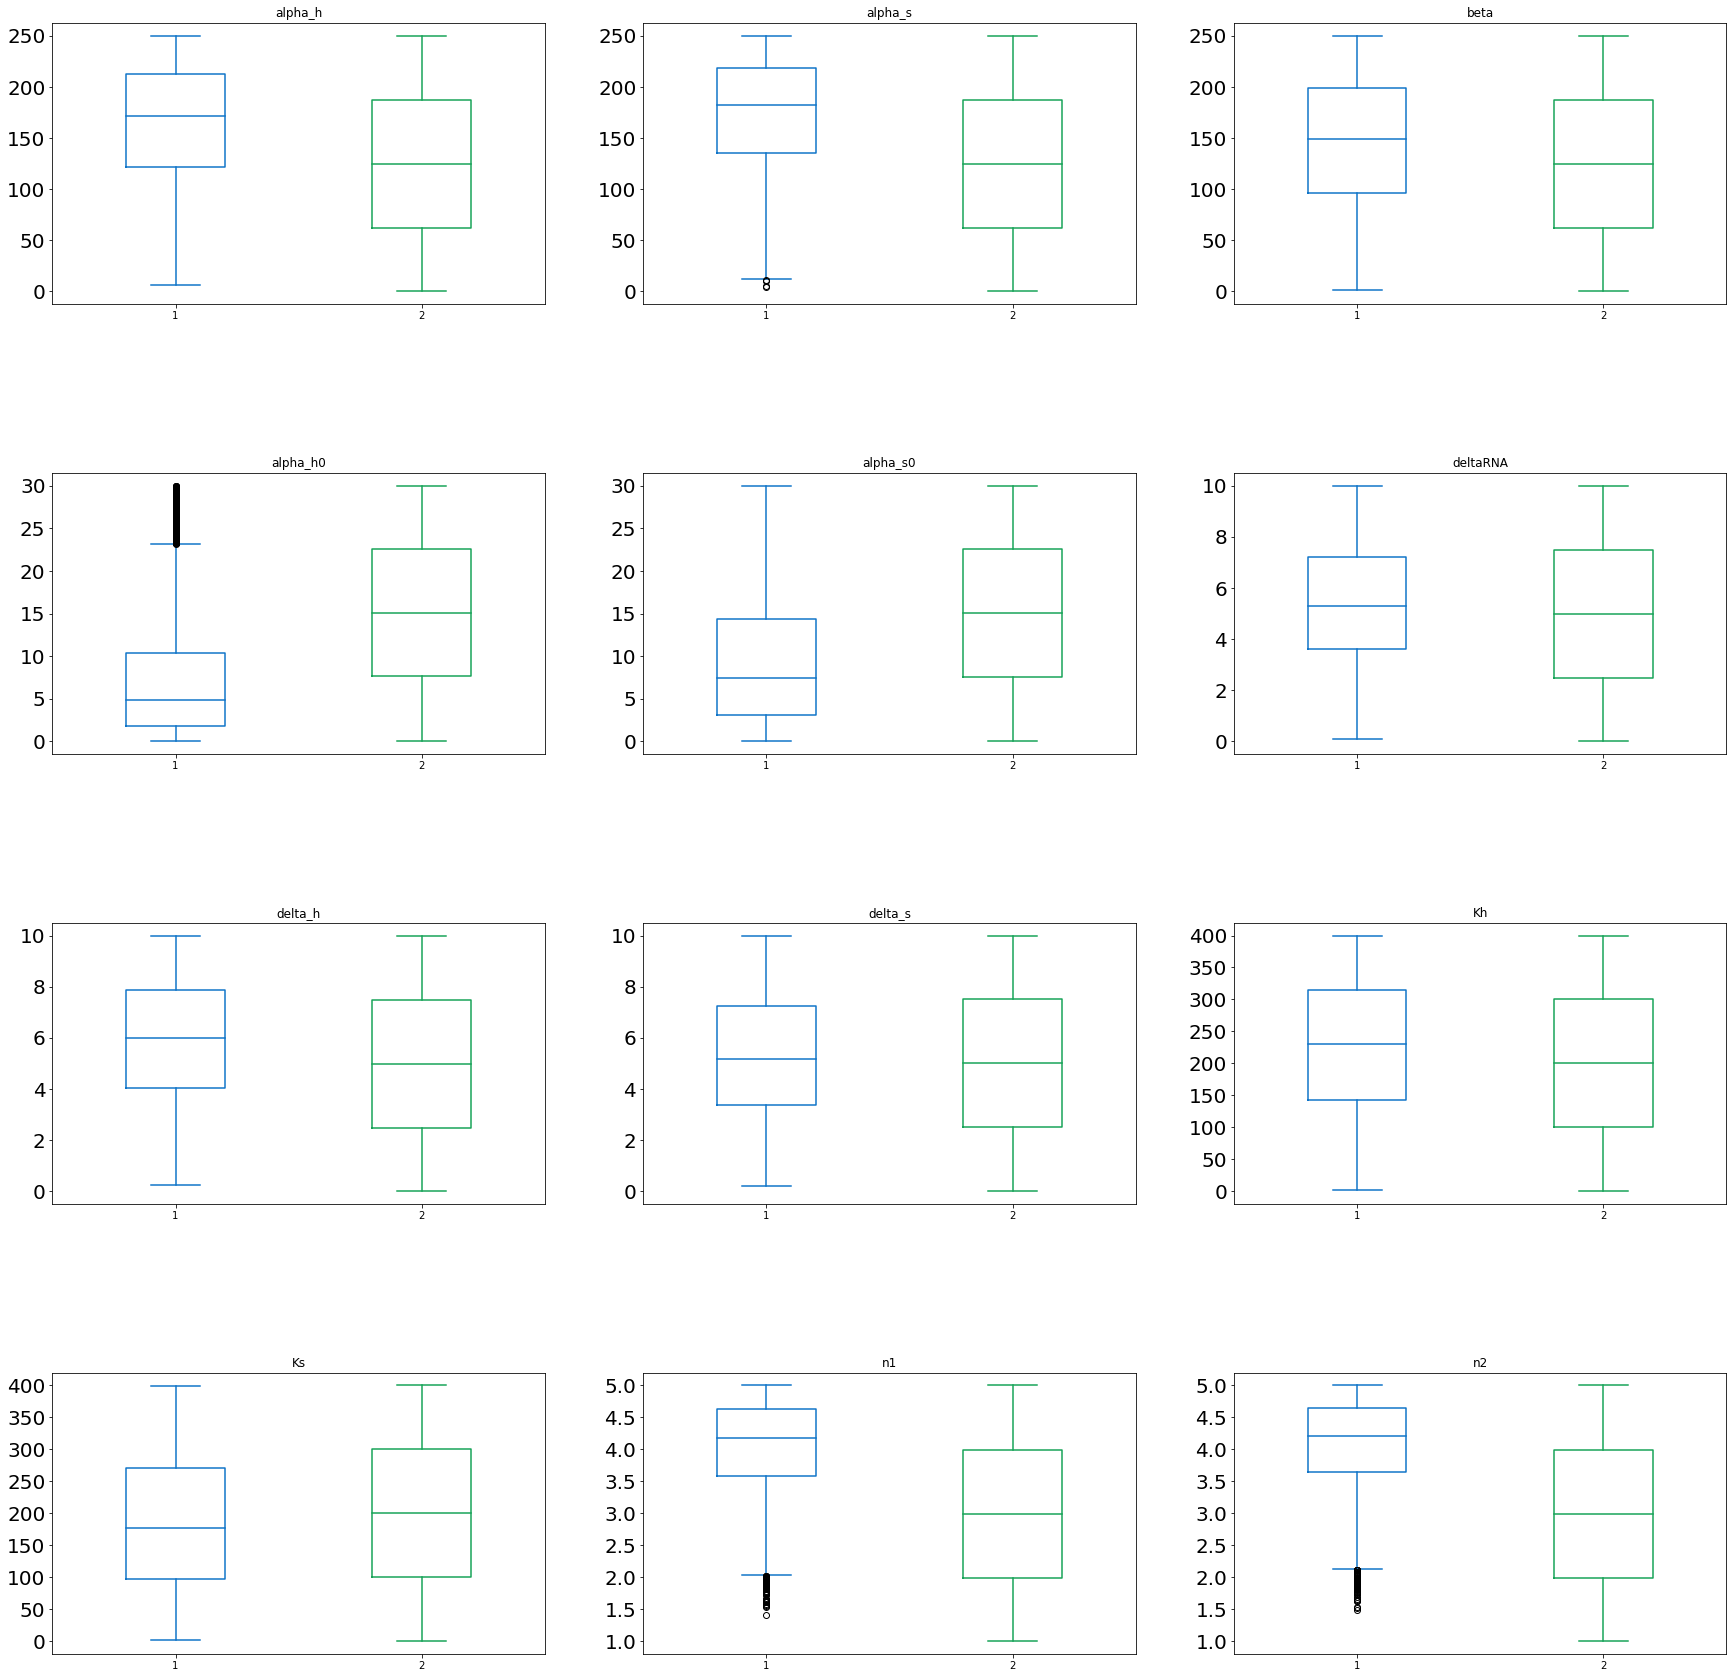

In [53]:
name=['alpha_h','alpha_s', 'beta', 'alpha_h0','alpha_s0','deltaRNA','delta_h','delta_s','Kh','Ks','n1','n2']
reg=[samples[0],samples[1]]
solver.plotParameterVariances(reg,name)
plt.savefig('parameter_plot.pdf',dpi=500,bbox_inches='tight')

In [87]:
can=[183,
    30.5,
    3.7,
    0.1,
    0.1,
    0.3,
    3.8,
    0.2,
    326.0,
    185.0,
    3.0,
    4.8]

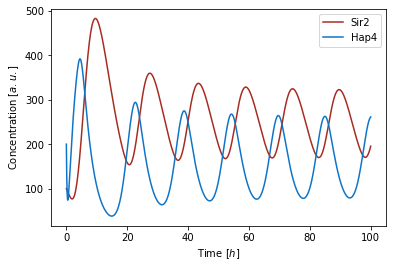

In [88]:
model.plotModel(can,show=False)